# Clustering

## Dimensionality Reduction & LSA
#### Dataset
- **Altitude** Altitude.MSL.Single Value
- **Distance** Relative Position.Distance.Nautical Miles
- **Report** combined narrative and summary stemmed
- **Narrative**
- **Summary**

In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import json as js
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture
%matplotlib inline

In [5]:
# Read report
new_report = pd.read_csv("02-ASRS-stemmed.csv", index_col=0)
new_report.head()

,Altitude,Distance,Narrative,Report,Summary
0,2500,9.0,F/O FLYING ACFT FROM LEFT SEAT. BLUE AND WHITE...,helicopt encount sma acft IN see avoid situat ...,HELICOPTER ENCOUNTERED SMA ACFT IN SEE AND AVO...
1,4500,22.0,WHILE LEVEL AT 4500'; HDG 246 DEGS ON VICTOR 1...,close prox ga-sma ga-smt ON v106 . level AT 45...,CLOSE PROX GA-SMA GA-SMT ON V106.
2,800,2.0,I WAS INVOLVED IN A NMAC WHILE ON FINAL APCH T...,close prox 2 ga-sma acft IN traffic pattern AT...,CLOSE PROX 2 GA-SMA ACFT IN TRAFFIC PATTERN AT...
3,3500,15.0,WHILE ON CROSS-COUNTRY VFR FROM ORANGE; MA TO ...,close prox GA sma parachutist IN restrict area...,CLOSE PROX GA SMA AND PARACHUTIST IN RESTRICTE...
4,1800,2.0,UPON REACHING MADISON VOR WE REQUESTED CLRNC D...,standard separaton nmac between commut sma acf...,LESS THAN STANDARD SEPARATON AND NMAC BETWEEN ...


In [6]:
# Word reference lookup helper
word_reference = pd.read_csv("02-ASRS-word-reference.csv", index_col=0)
def lookup(word):
    for i in range(len(word_reference)):
        if word_reference['after'][i] == word:
            print(word_reference['before'][i])
            break

lookup('ra')

In [15]:
# Tfid Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', min_df=4, max_df=0.8)
dtm = vectorizer.fit_transform(new_report['Report'])
print(dtm.shape)
dtm_dense = dtm.todense()
centered_dtm = dtm_dense - np.mean(dtm_dense, axis=0)
terms = vectorizer.get_feature_names()

(571, 1600)


In [16]:
# Decide n_components
svd = TruncatedSVD(n_components=100, algorithm="randomized")
svd_fit = svd.fit_transform(centered_dtm)
svd_norm = Normalizer().fit_transform(svd_fit)

vt = svd.components_
dfnorm = pd.DataFrame(svd_norm)

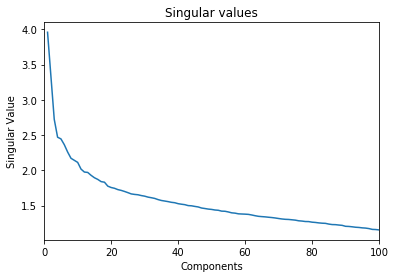

In [17]:
s = svd.singular_values_
plt.xlim([0,100])
plt.plot(range(1,len(s)+1),s)
plt.title('Singular values')
plt.ylabel('Singular Value')
plt.xlabel('Components')

In [18]:
svd = TruncatedSVD(n_components=10, algorithm="randomized")
svd_fit = svd.fit_transform(centered_dtm)
svd_norm = Normalizer().fit_transform(svd_fit)

vt = svd.components_
dfnorm = pd.DataFrame(svd_norm)

In [19]:
order_components = vt.argsort()[:, ::-1]
components = []
for i in range(vt.shape[0]):
    label = [terms[ind] for ind in order_components[i, :10]]
    components.append(label)
dfnorm.columns = components
dfnorm.head()

,tcasii,ft,ra,clb,tfc,atc,dscnt,visual,acr,ta
,acr,sector,radar,issu,ctlr,separ,error,hold,sep,zbw
,acr,twr,rwi,turn,apch,downwind,deg,tcasii,final,hdg
,aircraft,traffic,tower,acr,runway,approach,pilot,ra,downwind,flight
,sma,smt,hdg,deg,apch,clock,vfr,atc,tca,12
,sma,ra,tcasii,rptr,pattern,acft,radar,acr,final,alt
,apch,pvd,ctl,il,ra,vector,mht,aircraft,rwi,tcasii
,ft,sma,acr,10000,mht,9000,class,3000,dscnt,ash
,sma,acft,ft,dep,deg,hdg,7000,6000,5000,bo
,clb,dep,visual,mht,separ,zbw,maintain,sma,ctr,sector
0,-0.405151,-0.099000,-0.090591,0.003652,0.595133,0.509893,-0.212832,0.138115,0.370398,-0.045712


In [75]:
dfloc = pd.DataFrame(scale(new_report[['Distance', 'Altitude']]), columns=['Distance', 'Altitude'])
df_features = dfloc.join(dfnorm)
df_features['Distance'] = df_features['Distance'].apply(lambda x: x * 1)
df_features['Altitude'] = df_features['Altitude'].apply(lambda x: x * 1)
df_features.to_csv('03-lsa.csv')
df_features.head()

/Users/aslstem/anaconda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 10 on the right)
  warnings.warn(msg, UserWarning)


,Distance,Altitude,"(tcasii, acr, acr, aircraft, sma, sma, apch, ft, sma, clb)","(ft, sector, twr, traffic, smt, ra, pvd, sma, acft, dep)","(ra, radar, rwi, tower, hdg, tcasii, ctl, acr, ft, visual)","(clb, issu, turn, acr, deg, rptr, il, 10000, dep, mht)","(tfc, ctlr, apch, runway, apch, pattern, ra, mht, deg, separ)","(atc, separ, downwind, approach, clock, acft, vector, 9000, hdg, zbw)","(dscnt, error, deg, pilot, vfr, radar, mht, class, 7000, maintain)","(visual, hold, tcasii, ra, atc, acr, aircraft, 3000, 6000, sma)","(acr, sep, final, downwind, tca, final, rwi, dscnt, 5000, ctr)","(ta, zbw, hdg, flight, 12, alt, tcasii, ash, bo, sector)"
0,-0.214551,-0.640337,-0.405151,-0.099000,-0.090591,0.003652,0.595133,0.509893,-0.212832,0.138115,0.370398,-0.045712
1,0.237947,-0.373952,-0.370280,0.067288,-0.012567,-0.191073,0.832264,-0.143782,-0.028335,-0.304067,-0.110985,-0.052758
2,-0.458203,-0.866764,-0.646871,-0.355758,0.161791,-0.009152,0.006588,0.557895,-0.199345,-0.075597,0.171882,-0.206029
3,-0.005706,-0.507144,-0.599174,-0.034482,-0.492461,0.251356,0.233807,0.237030,-0.069228,0.410238,-0.223436,-0.015609
4,-0.458203,-0.733571,-0.647154,-0.284178,0.418002,-0.478627,0.168112,-0.016107,0.013648,-0.253685,0.000073,0.059683


Full forms of the above abbreviations:
1. 
2. 
3. 
4.
5.
1. aircaft, error, standard, system, separation, between, Less Than Standard Separation
2. control, boston air route traffic control center, experience, operator, at, separation, standard, feet
3. Traffic Alert and Collision Avoidance, to, alert, aircaft, Resolution Advisory, Less Than Standard Separation, assign, descdent
4. runways, on, aircraft, approach, experience, Less Than Standard Separation, operator, error
5. Resolution Advisory, Traffic Alert and Collision Avoidance, report, crew, aircraft, approach runway, control

1. Near mid air collision, , , Pattern
2. aircraft, error, standard, Near mid air collision,
3. separate, 
4.
5.

Explain deciding n_components; number of clusters...

## Analysis

1. midair collision sma has pattern / less than standard separation system error oppuacied
2. aircarrier error standard midair collision / in separate standard aircraft
3. nmac operator 

## K-means

In [76]:
k = 5
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1)
kmeans.fit_predict(df_features)
Kcentroids = kmeans.cluster_centers_
Klabels = kmeans.labels_
print(Klabels.shape)

(571,)


In [77]:
# Name k clusters
Kasc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
Korder_centroids = Kasc_order_centroids[:,::-1]
Korder_centroids = np.array([[x - 2 for x in row if (x - 2) >= 0] for row in Korder_centroids]) # remove locations

Kcluster_names = []
for i in range(k):
    label = [components[ind] for ind in Korder_centroids[i, :2]]
    Kcluster_names.append(label)

In [78]:
def find_report(cluster_num):
    report = [new_report.iloc[i]['Summary'] for i in range(len(Klabels)) if Klabels[i] == cluster_num]
    return report

# Sample Report
find_report(4)

['LGT ON IFR ARR ROUTE WAS GIVEN TRAFFIC ON UNK-SMT B WHO LATER TOOK EVASIVE ACTION MISS THE LGT.',
 'ACR-MLG FLT CREW SIGHTED AND TOOK ACTION TO AVOID AN ACR-LGT CONVERGING AT THE SAME ALT.',
 'NMAC BETWEEN COMMUTER AND CORP ACFT. SEE AND AVOID SITUATION. REPORT WAS ON OLD FAA FORM 8020-12.',
 'EVASIVE ACTION TO AVOID COLLISION WITH SMT DESCENDING OUT OF OVERCAST THROUGH VFR.',
 'ACFT OVERSHOT ASSIGNED ALT AND CAME IN CLOSE PROX TO AN IFR ACFT ABOVE HIM.',
 'CLOSE PROX GA-SMA FLYING VFR OVER THE BOS TCA AND ACR CLIMBING OUT.',
 'CPR-SMA IS SURPRISED BY AN ACR-MLG CLIMBING RAPIDLY OUT OF THE UNDERCAST.',
 'TRAFFIC ADVISORIES BUT HAS NMAC WITH SMT CLIMBING.',
 'SMA WAS VECTORED FOR TRAFFIC AT THE SAME ALT; BUT LOSS OF SEPARATION OCCURRED.',
 'CLOSE PROX ACR-LGT GA-SMA 40 NORTHEAST OF PVD.',
 'ACR CAME IN CLOSE PROX TO AN SMT DURING DESCENT.',
 'LESS THAN STANDARD SEPARATION BETWEEN ACR Y AND SMT X. SYSTEM ERROR.',
 "PLT DEVIATED FROM ASSIGNED ALT WHICH CAUSED AN NMAC WITH 4 FGT'S.",
 'A

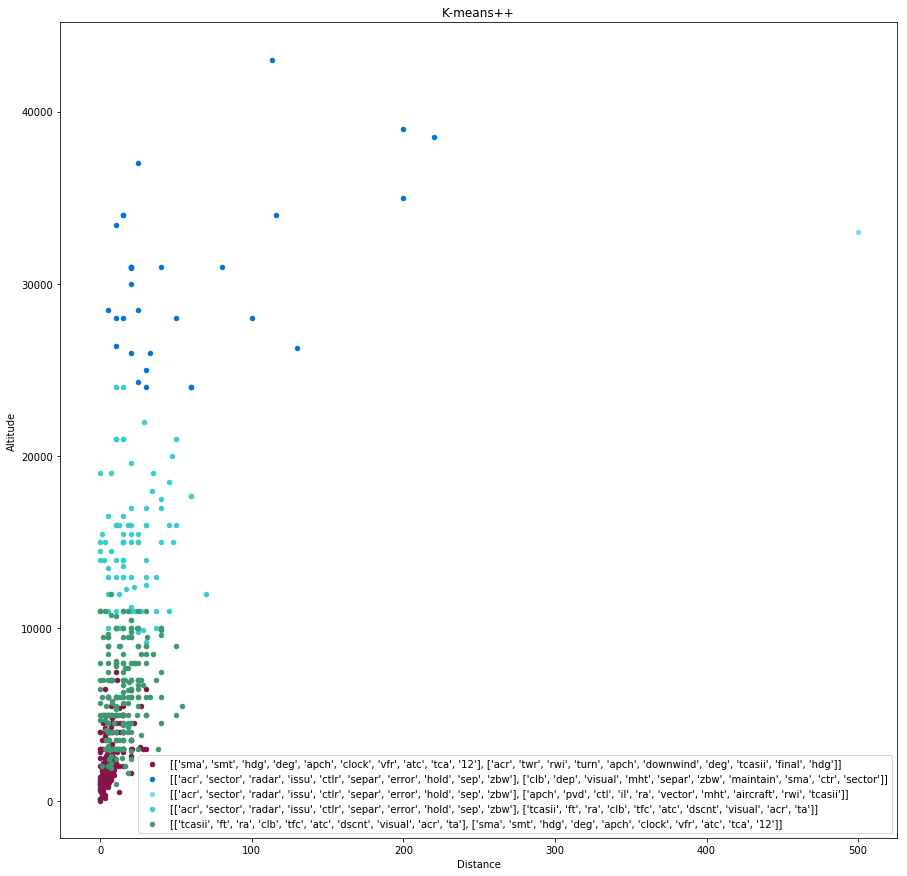

In [79]:
# Plot k-means++
plt.figure(figsize=(15, 15))
colors = ['#85144b', '#0074D9', '#7FDBFF', '#39CCCC', '#3D9970', '#2ECC40', '#01FF70', '#FFDC00', '#FF851B', '#FF4136', '#AAAAAA', '#222222']

for cluster_index in range(k):
    dis = [new_report.iloc[i]['Distance'] for i in range(len(Klabels)) if Klabels[i] == cluster_index]
    alt = [new_report.iloc[i]['Altitude'] for i in range(len(Klabels)) if Klabels[i] == cluster_index]
    plt.scatter(x=dis, y=alt, c=colors[cluster_index], label = Kcluster_names[cluster_index], s=20)

plt.legend()
plt.xlabel('Distance')
plt.ylabel('Altitude')
plt.title('K-means++')
plt.show()

1. Traffic Collision Avoidence System / FT / Radar Advisory Service / Climb / Air Traffic Control / Traffic / Visual / accident / descent / true air speed
2. Traffic / Apching (What is this?) / sector (a portion of an itinerary) / Visual / Control / Bradley International Airport / Boston Air Route Traffic Control Center (ZBW) / climb / jet
3. Aircraft / sector / issue / radar / control / separation / error / holding / sep (single Engine Piston) / hdg (Heading Mode The autopilot keeps the nose of the airplane pointed at the magnetic heading bug)
4. aircraft / sma (a type of engine) / traffic / smt (SMT RDL 084 is simply a lead radial, so it is there to let you know when to start your turn) / tower / runaway / approach / clock / hdg (Heading Mode The autopilot keeps the nose of the airplane pointed at the magnetic heading bug) / atc (air traffic control)
5. Traffic / Apching (What is this?) / sector (a portion of an itinerary) / Visual / Control / Bradley International Airport / Boston Air Route Traffic Control Center (ZBW) / climb / jet

The usual flying altitude of an aircraft is 39,000 feet. 
Observation: 
1. The lower the altitude, collision is more likely to happen. 
2. At low altitude collision (< 8,000), from the text analysis we can see they happen with climbing and descent, the parameters which may affect the collision are: true air speed, control of the airplane, heading mode, radar, radar advisory service, visual, and happens frequently among sinle engine piston. 
3. At high altitude collision (8,000 ~ 3,6000), from the text analysis we can see they happen during sector(a portion of an itinerary) or climb, and associates more with the arrangement of the traffic control center and airport, visual may also counts as a factor. 

## Hierarchical

In [80]:
k = 5
euclidean = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean').fit(df_features)
Hlabels = euclidean.labels_
print(Hlabels.shape)

(571,)


In [81]:
# Find centroids for each cluster
def find_centroids(k, label):
    centroids = []
    for cluster_label in range(k):
        features_list = [df_features.values[index] for index in range(len(label)) if label[index] == cluster_label]
        sum_features = np.sum(features_list, axis=0)
        mean_features = [x/len(features_list) for x in sum_features]
        centroids.append(mean_features)
    return np.array(centroids)
Hcentroids = find_centroids(k, Hlabels)

In [82]:
# Name k Hierarchical clusters
Hasc_order_centroids = Hcentroids.argsort()#[:, ::-1]
Horder_centroids = Hasc_order_centroids[:,::-1]
Horder_centroids = np.array([[x - 2 for x in row if (x - 2) >= 0] for row in Horder_centroids]) # remove locations

Hcluster_names = []
for i in range(k):
    label = [components[ind] for ind in Horder_centroids[i, :2]]
    Hcluster_names.append(label)

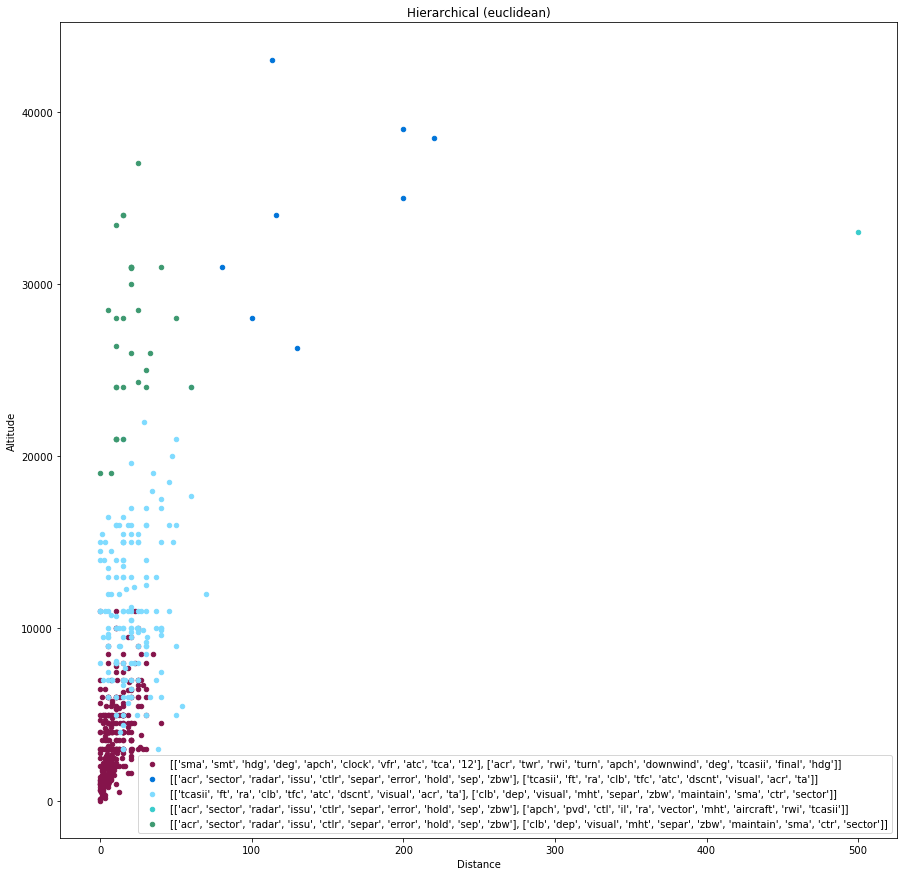

In [83]:
# Plot Hierarchical
plt.figure(figsize=(15, 15))
colors = ['#85144b', '#0074D9', '#7FDBFF', '#39CCCC', '#3D9970', '#2ECC40', '#01FF70', '#FFDC00', '#FF851B', '#FF4136', '#AAAAAA', '#222222']

for cluster_index in range(k):
    dis = [new_report.iloc[i]['Distance'] for i in range(len(Hlabels)) if Hlabels[i] == cluster_index]
    alt = [new_report.iloc[i]['Altitude'] for i in range(len(Hlabels)) if Hlabels[i] == cluster_index]
    plt.scatter(x=dis, y=alt, c=colors[cluster_index], label = Hcluster_names[cluster_index], s=20)

plt.legend()
plt.xlabel('Distance')
plt.ylabel('Altitude')
plt.title('Hierarchical (euclidean)')
plt.show()

## GMM

In [84]:
k = 5
gmm = mixture.GaussianMixture(n_components=k, covariance_type='spherical')
gmm.fit(df_features)
Gcentroids = gmm.means_
Glabels = gmm.predict(df_features)
print(Glabels.shape)

(571,)


In [85]:
# Name k Hierarchical clusters
Gasc_order_centroids = Gcentroids.argsort()#[:, ::-1]
Gorder_centroids = Hasc_order_centroids[:,::-1]
Gorder_centroids = np.array([[x - 2 for x in row if (x - 2) >= 0] for row in Horder_centroids]) # remove locations

Gcluster_names = []
for i in range(k):
    label = [components[ind] for ind in Gorder_centroids[i, :2]]
    Gcluster_names.append(label)

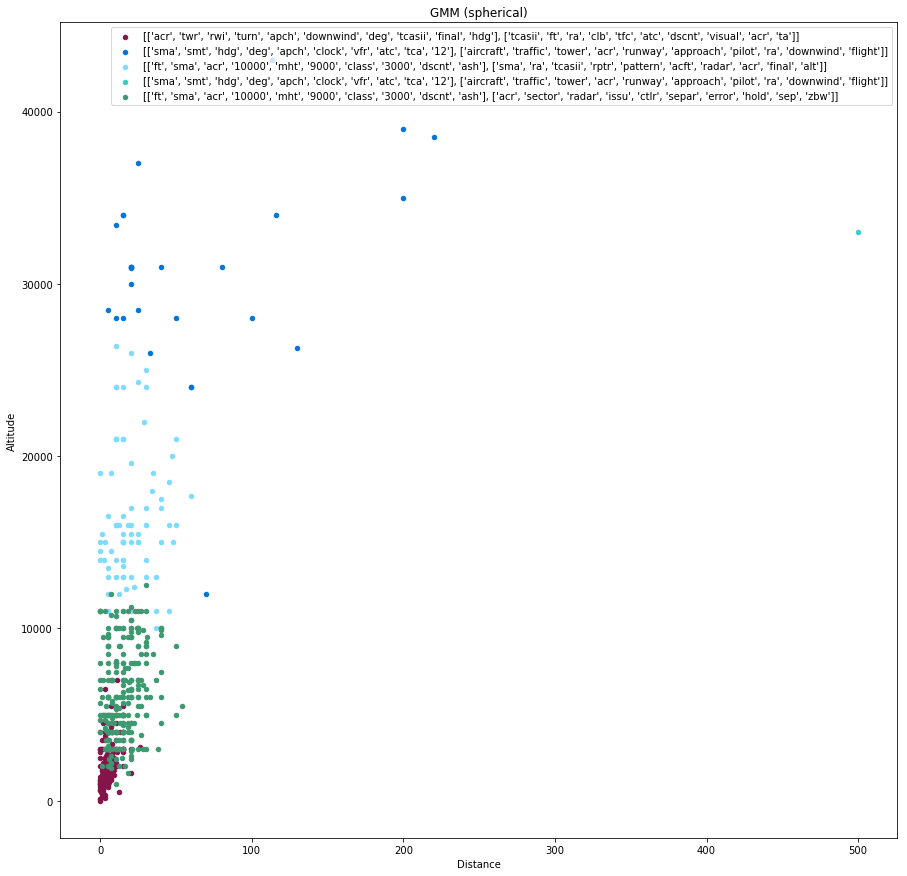

In [86]:
# Plot GMM
plt.figure(figsize=(15, 15))
colors = ['#85144b', '#0074D9', '#7FDBFF', '#39CCCC', '#3D9970', '#2ECC40', '#01FF70', '#FFDC00', '#FF851B', '#FF4136', '#AAAAAA', '#222222']

for cluster_index in range(k):
    dis = [new_report.iloc[i]['Distance'] for i in range(len(Glabels)) if Glabels[i] == cluster_index]
    alt = [new_report.iloc[i]['Altitude'] for i in range(len(Glabels)) if Glabels[i] == cluster_index]
    plt.scatter(x=dis, y=alt, c=colors[cluster_index], label = Gcluster_names[cluster_index], s=20)

plt.legend()
plt.xlabel('Distance')
plt.ylabel('Altitude')
plt.title('GMM (spherical)')
plt.show()

Explain Some variable we play around with:
- k
- scale location (we do not want the location vectors to be too dominant to make the text features meaningless)